In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

# MNIST

http://yann.lecun.com/exdb/mnist/

Base de datos de digitos escritos a mano.

* 60,000 imágenes de entrenamiento.
* 10,000 imágenes de test.

Cada imagen es de 28x28, en escala de grises.

In [3]:
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(f'Train -> x: {x_train.shape}')
print(f'         y: {y_train.shape}')
print(f'Test -> x: {x_test.shape}')
print(f'        y: {y_test.shape}')

/home/manuel/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Train -> x: (60000, 28, 28)
         y: (60000,)
Test -> x: (10000, 28, 28)
        y: (10000,)


In [4]:
#Normalizar
x_train = (x_train - 127.5 ) / 127.5
x_test = (x_test - 127.5 ) / 127.5

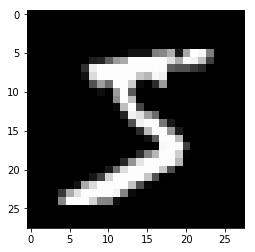

In [5]:
# Veamos una muestra
plt.imshow(x_train[0], 'gray');

## Ajustamos las dimensiones de las imágenes

Para usar las imágenes en una multiplicación de matrices, esta necesita tener sólo 2 dimensiones.

In [6]:
x_train.shape

(60000, 28, 28)

In [7]:
x_train = x_train.reshape([60000, 28*28])
x_test = x_test.reshape([10000, 28*28])
x_train.shape, x_test.shape

((60000, 784), (10000, 784))

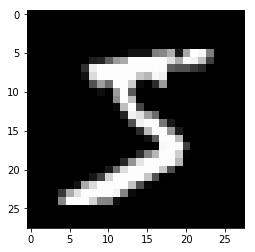

In [8]:
# Podemos usar el reshape de nuevo, para mostrar la imagen
plt.imshow(x_train[0].reshape([28,28]), 'gray');

## Definimos un modelo

In [9]:
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD

lr = 0.01
bs = 256
nb = math.ceil(len(x_train)/bs) # Nro de batches

model = Sequential([
    Dense(128, activation='relu', input_shape=(784,)),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

model.compile(SGD(lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
# La pérdida 'sparse_categorical_crossentropy' realiza automaticamente la conversión
# del target a one-hot encoding.

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 109,386
Trainable params: 109,386
Non-trainable params: 0
_________________________________________________________________


## Usemos el método de Learning rate finder

In [10]:
from custom_callbacks import LrFinder, reset_weights

lr_finder = LrFinder(nb)

model.fit(x_train, y_train, batch_size=bs, callbacks=[lr_finder]);

Epoch 1/1
43264/60000 [====================>.........] - ETA: 0s - loss: 2.1525 - acc: 0.2376

In [ ]:
lr_finder.plot_lr()

In [ ]:
lr_finder.plot()

In [ ]:
lr = 2e-3

## Entrenamiento

In [ ]:
# Reseteamos los pesos y compilamos el modelo con el nuevo lr
reset_weights(model)
model.compile(SGD(lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
log = model.fit(x_train, y_train, batch_size=bs, epochs=6, validation_data=[x_test, y_test])

In [ ]:
def show_results(model, log, cycling=False):
    loss, acc = model.evaluate(x_test, y_test, batch_size=512, verbose=False)
    print(f'Loss     = {loss:.4f}')
    print(f'Accuracy = {acc:.4f}')
    
    val_loss = log.history['val_loss']
    val_acc = log.history['val_acc']
    if cycling:
        val_loss += [loss]
        val_acc += [acc]
        
    fig, axes = plt.subplots(1, 2, figsize=(14,4))
    ax1, ax2 = axes
    ax1.plot(log.history['loss'], label='train')
    ax1.plot(val_loss, label='test')
    ax1.set_xlabel('epoch'); ax1.set_ylabel('loss')
    ax2.plot(log.history['acc'], label='train')
    ax2.plot(val_acc, label='test')
    ax2.set_xlabel('epoch'); ax2.set_ylabel('accuracy')
    for ax in axes: ax.legend()

In [ ]:
show_results(model, log)

## Cycling learning rates

In [ ]:
from custom_callbacks import CycleLearner

cycle_learner = CycleLearner(lr, nb, n_cycle=3)

In [ ]:
reset_weights(model)
log = model.fit(x_train, y_train, batch_size=bs, epochs=100,
                validation_data=[x_test, y_test], callbacks=[cycle_learner])
# Nota: la cantidad de epocas la va a controlar el callback.

In [ ]:
cycle_learner.plot_lr()
show_results(model, log, cycling=True)

In [ ]:
# El parametro "cycle_mult" permite que cada ciclo sea mayor al anterior,
# en este caso el doble del anterior

# Esta vez no reseteamos los parametros
# pero vamos a disminuir el learning rate

cycle_learner = CycleLearner(lr/2, nb, n_cycle=3, cycle_mult=2)
log = model.fit(x_train, y_train, batch_size=bs, epochs=100,
                validation_data=[x_test, y_test], callbacks=[cycle_learner])

In [ ]:
cycle_learner.plot_lr()
show_results(model, log, cycling=True)

## Snapshot ensembles

In [ ]:
# Iniciamos el entrenamiento de forma normal
reset_weights(model)
cycle_learner = CycleLearner(lr, nb, n_cycle=3, cycle_mult=2)
log = model.fit(x_train, y_train, batch_size=bs, epochs=100,
                validation_data=[x_test, y_test], callbacks=[cycle_learner])

In [ ]:
# Ahora activamos los snapshots
cycle_learner = CycleLearner(lr/2, nb, n_cycle=3, cycle_len=2, snapshots=True, snapshots_name='mnist_test')
log = model.fit(x_train, y_train, batch_size=bs, epochs=100,
                validation_data=[x_test, y_test], callbacks=[cycle_learner])

In [ ]:
# Noten la diferencia de usar "cycle_len=2" en lugar de "cycle_mult=2" en CycleLearner
cycle_learner.plot_lr()
show_results(model, log, cycling=True)

In [ ]:
# Veamos los archivos creados para los snapshots
from pathlib import Path

snapshots = Path('snapshots')
for file in snapshots.iterdir():
    print(file)

In [ ]:
# Veamos ahora usando snapshots
snapshots_results = np.zeros([10000,10])

for file in snapshots.iterdir():
    model.load_weights(file)
    snapshots_results += model.predict(x_test) / 3
    
acc = (snapshots_results.argmax(axis=1) == y_test).mean()
print(f'Snapshot accuracy = {acc}')

# Ejercicio

Variar la arquitectura de la red y experimentar con las técnicas vistas en clase:
* Weight initialization.
* Regularización (Dropout, BatchNormalization).
* Distintos algoritmos de optimización.

In [ ]:
# COMPLETAR

# Otra base de datos para practicar:

``` python
from keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
```

In [ ]:
# COMPLETAR